In this notebook, we're going to perform style transfer, we'll use a pretrained network as well here (VGG19).

In [ ]:
%tensorflow_version 2.x

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import tensorflow.keras.applications.vgg19 as vgg19
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from skimage import io
from scipy.optimize import fmin_l_bfgs_b

We're going to use the same `KerasFunctionOptimizer` class we've written earlier to do the optimization for us. Since this calculates gradients and wants TensorFlow's eager execution disabled, we're just going to go ahead and disable it for the remainder of the notebook.

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

Next, we define paths to our base (original) and style (reference) image. You can try using different URLs or images here should you like to.

In [ ]:
base_image_path  = 'http://mg.bluecourses.com/wp-content/uploads/2020/04/cat.jpg'
style_image_path = 'http://mg.bluecourses.com/wp-content/uploads/2020/04/picasso.jpg'

Since we use a pretrained network, we again define a function to help us preprocess an image. We're also going to define a function to deprocess and image, as we want to show it to the user.



In [ ]:
def preprocess_image(path, resize=False):
  image_original  = sk_load_img(path)
  image_processed = image_original.copy()
  if resize is not False: image_processed = image_processed.resize(resize)
  image_processed = image.img_to_array(image_processed)
  image_processed = np.expand_dims(image_processed, axis=0)
  image_processed = vgg19.preprocess_input(image_processed)
  return image_original, image_processed

In [ ]:
def deprocess_image(arr, size):
  x = np.copy(arr).reshape(size + (3, ))
  # VGG19 preprocess by normalizing each channel with the ImageNet means, so we just add these back up
  # Want to know where this comes from? See https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py#L135
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  # We also need to convert back from (blue, green, red) to (red, green, blue)
  x = x[:, :, ::-1]
  # Finally, we clip all values between 0 and 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

Let's process our images and show the originals. We'll also resize the images to the same size.

In [ ]:
img_ncols, img_nrows   = 800, 600

In [ ]:
# Helper function to read an image from an URL
def sk_load_img(url):
  return Image.fromarray(io.imread(url))

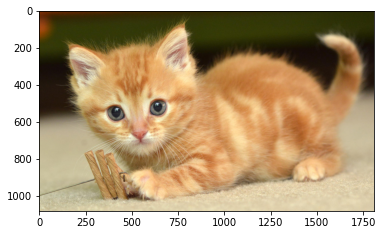

In [ ]:
base_img_original, base_img_processed = preprocess_image(base_image_path, (img_ncols, img_nrows))
plt.imshow(base_img_original); plt.show()

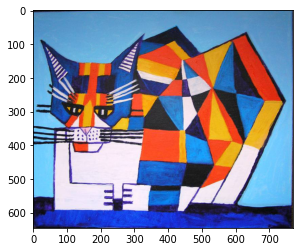

In [ ]:
style_img_original, style_img_processed = preprocess_image(style_image_path, (img_ncols, img_nrows))
plt.imshow(style_img_original); plt.show()

Finally, let's check whether our shapes are correct.

Note: most image operations in Python libraries work by using cols x rows, whereas the tensor define them as being rows x cols.

In [ ]:
base_img_processed.shape, style_img_processed.shape

((1, 600, 800, 3), (1, 600, 800, 3))

Finally, we can also test whether our deprocessing works. Here's a preprocessed image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


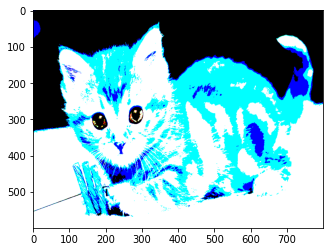

In [ ]:
plt.imshow(base_img_processed.squeeze(axis=0)); plt.show()

And the deprocessed one:

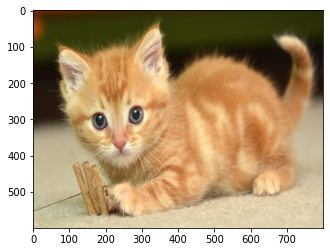

In [ ]:
plt.imshow(deprocess_image(base_img_processed, (img_nrows, img_ncols))); plt.show()

We going to use quite an amount of loss functions here, so let's start off by defining these:

In [ ]:
# Difference between base and combined image, using SSE
def content_loss(base, combination):
  return K.sum(K.square(combination - base))

# Difference between combined image and style image, using SSE on difference of their gram matrices, normalized
def style_loss(style, combination):
  assert K.ndim(style) == 3
  assert K.ndim(combination) == 3
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_nrows * img_ncols
  return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# Gram matrix: dot product between a matrix and its transposed one
def gram_matrix(x):
  assert K.ndim(x) == 3
  # Put the channels / depth in front and flatten to a 2d array
  features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
  gram = K.dot(features, K.transpose(features))
  return gram

# Distance between neighboring pixels, without taking the border into account
def total_variation_loss(x, p=1.25):
  assert K.ndim(x) == 4
  a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
  b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
  return K.sum(K.pow(a + b, p))

We're now ready to define our optimizer class. We're going to write this very much in the same style as the one we used in the interpretability example.

Our situation is as follows, starting off with our original image, optimize that in such a way so as to minimize the losses defined above.

In [ ]:
class StyleTransferOptimizer(object):
  def __init__(self, base_img_processed, style_image_processed):
    # Create Keras variables. All of these have the shape (1, img_nrrows, img_nrcols, 3)
    self.base_img_processed    = K.variable(base_img_processed)
    self.style_image_processed = K.variable(style_img_processed)
    self.combination_image     = K.placeholder(base_img_processed.shape)
    # self.combination_image is the image we're actually going to optimize
    # Combined image: all these three images slapped together
    self.input_tensor          = K.concatenate([self.base_img_processed, self.style_image_processed, self.combination_image], axis=0)
    # Pretrained model, without the top as we won't need it here
    self.model                 = vgg19.VGG19(input_tensor=self.input_tensor, weights='imagenet', include_top=False)

  def configure_losses(self, losses):
    # Allow the user to configure the losses and define the Keras function
    # We can't do this in init as the user might want to use the input_tensor
    self.loss         = K.variable(0.)
    for loss in losses: self.loss = self.loss + loss
    # Calculate the gradients: loss w.r.t. the combination image
    self.gradients    = K.gradients(self.loss, self.combination_image)
    self.outputs      = [self.loss, self.gradients]
    self.function     = K.function([self.combination_image], self.outputs)

  def _evaluate(self, x):
    # fmin_l_bfgs_b gave us an 1d array, so we reshape x back to format of our combination image
    x = x.reshape(self.combination_image.shape)
    outputs = self.function([x])
    return outputs[0], np.array(outputs[1:]).flatten().astype('float64')

  def _get_loss(self, x):
    self.last_loss, self.last_gradients = self._evaluate(x)
    return self.last_loss

  def _get_gradients(self, x):
    return np.copy(self.last_gradients)

  def optimize(self, x, **args):
    # fmin_l_bfgs_b expects a 1d array, so we flatten x
    x, min_val, info = fmin_l_bfgs_b(self._get_loss, x.flatten(), fprime=self._get_gradients, **args)
    # We also deprocess x so that the user can easily display it
    img = deprocess_image(x.copy(), (self.combination_image.shape[1], self.combination_image.shape[2]))
    return x, img, min_val, info

In [ ]:
optimizer = StyleTransferOptimizer(base_img_processed, style_img_processed)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
80142336/80134624 [==============================] - 2s 0us/step


Next, we define the weights for these losses. Again, this is a set of hyperparameters you can tune:

In [ ]:
total_variation_weight = 1.0
style_weight           = 1.0
content_weight         = 0.025

And configure our different losses...

In [ ]:
model_layers_to_output = dict([(layer.name, layer.output) for layer in optimizer.model.layers])

# Content loss
content_intermediate_conv_output = model_layers_to_output['block5_conv2']
content_base_image_features      = content_intermediate_conv_output[0, :, :, :]
content_combination_features     = content_intermediate_conv_output[2, :, :, :]
content_loss_def                 = content_weight * content_loss(content_base_image_features, content_combination_features)

# Style loss
style_losses_def = []
style_intermediate_conv_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
for style_intermediate_conv_name in style_intermediate_conv_names:
  style_intermediate_conv_output   = model_layers_to_output[style_intermediate_conv_name]
  style_style_image_features       = style_intermediate_conv_output[1, :, :, :]
  style_combination_image_features = style_intermediate_conv_output[2, :, :, :]
  style_loss_def                   = style_loss(style_style_image_features, style_combination_image_features)
  style_losses_def.append( (style_weight / len(style_intermediate_conv_names)) * style_loss_def )
    
# Local variation loss
local_variation_loss_def = total_variation_weight * total_variation_loss(optimizer.combination_image)

optimizer.configure_losses([
  content_loss_def,
  local_variation_loss_def
] + style_losses_def)

Phew... now, we can finally start to optimize our combined image. We're going to do this step by step by limiting the `maxfun` function calls, so we can see our image gradually changing. Our optimizer expects a preprocessed image, and we're simply going to start with the original image.

In [ ]:
iterations               = 30
combined_image_processed = base_img_processed.copy()

for i in range(iterations):
  combined_image_processed, combined_image_deprocessed, min_val, info = optimizer.optimize(combined_image_processed, maxfun=30)
  print('Iteration', i, ' loss = ', min_val)
  plt.figure(figsize=(4, 5))
  plt.imshow(combined_image_deprocessed)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.